In [ ]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
import os

# 1. Register NEU-Seg
TRAIN_JSON = "<Domain_A_training_data_annotations_json_file>"
TRAIN_IMG_DIR = "<Domain_A_training_data_images>"
VAL_JSON = "<Domain_A_evaluation_data_annotations_json_file>"
VAL_IMG_DIR = "<Domain_A_evaluation_data_images>"

# Register or Skip if exists
try:
    register_coco_instances("neu_train", {}, TRAIN_JSON, TRAIN_IMG_DIR)
    register_coco_instances("neu_valid", {}, VAL_JSON, VAL_IMG_DIR)
except AssertionError:
    pass 

# --- THE FIX IS HERE ---
# Force Detectron2 to load the data immediately so it finds the class names
print("⏳ Loading dataset annotations to find classes...")
dataset_dicts = DatasetCatalog.get("neu_train") 

# Now the metadata will be populated!
metadata = MetadataCatalog.get("neu_train")
num_classes = len(metadata.thing_classes)
print(f"✅ Registered NEU-Seg with {num_classes} classes: {metadata.thing_classes}")
# ---------------------

⏳ Loading dataset annotations to find classes...
WARNING [11/18 17:17:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/18 17:17:08 d2.data.datasets.coco]: Loaded 1420 images in COCO format from /home/aamena/Assessment_tcs/datasets/NEU-seg-DOMAIN_A/train/_annotations.coco.json
✅ Registered NEU-Seg with 4 classes: ['In-"Pa",-"Sc"', 'In', 'Pa', 'Sc']


In [4]:
cfg = get_cfg()

# 1. Load the Mask R-CNN Architecture
# We use the R50-FPN model (ResNet-50 Feature Pyramid Network)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# 2. Point to the Dataset we just registered
cfg.DATASETS.TRAIN = ("neu_train",)
cfg.DATASETS.TEST = ("neu_valid",)
cfg.DATALOADER.NUM_WORKERS = 2

# 3. Hyperparameters (Tuned for RTX 4050 6GB)
cfg.SOLVER.IMS_PER_BATCH = 4        # ⚠️ Keep this small to save memory!
cfg.SOLVER.BASE_LR = 0.00025        # Learning rate
cfg.SOLVER.MAX_ITER = 5000          # Train for 1000 steps (approx 15 mins)
cfg.SOLVER.STEPS = []               # No learning rate decay

# 4. Model Head Settings
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # Uses the '4' we found earlier

# 5. Output Directory
cfg.OUTPUT_DIR = "./output/domain_a_baseline"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print(f"🚀 Starting Training on {num_classes} classes...")
print("This will take about 10-15 minutes. Watch the 'total_loss' go down!")

# 6. GO!
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

🚀 Starting Training on 4 classes...
This will take about 10-15 minutes. Watch the 'total_loss' go down!
[11/18 17:17:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[11/18 17:17:12 d2.engine.train_loop]: Starting training from iteration 0


/home/aamena/Assessment_tcs/.venv/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
W1118 17:17:13.526000 24707 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[11/18 17:17:24 d2.utils.events]:  eta: 0:49:29  iter: 19  total_loss: 3.301  loss_cls: 1.585  loss_box_reg: 0.4239  loss_mask: 0.6931  loss_rpn_cls: 0.4249  loss_rpn_loc: 0.07963    time: 0.5810  last_time: 0.5962  data_time: 0.0077  last_data_time: 0.0033   lr: 4.9953e-06  max_mem: 2701M
[11/18 17:17:36 d2.utils.events]:  eta: 0:48:16  iter: 39  total_loss: 3.043  loss_cls: 1.38  loss_box_reg: 0.4771  loss_mask: 0.6927  loss_rpn_cls: 0.2962  loss_rpn_loc: 0.05465    time: 0.5800  last_time: 0.5789  data_time: 0.0044  last_data_time: 0.0060   lr: 9.9902e-06  max_mem: 2701M
[11/18 17:17:48 d2.utils.events]:  eta: 0:48:04  iter: 59  total_loss: 2.768  loss_cls: 1.079  loss_box_reg: 0.5742  loss_mask: 0.6906  loss_rpn_cls: 0.3106  loss_rpn_loc: 0.07182    time: 0.5771  last_time: 0.4936  data_time: 0.0042  last_data_time: 0.0040   lr: 1.4985e-05  max_mem: 2701M
[11/18 17:17:59 d2.utils.events]:  eta: 0:47:36  iter: 79  total_loss: 2.306  loss_cls: 0.816  loss_box_reg: 0.596  loss_mask: 0

[11/18 18:24:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/aamena/Assessment_tcs/output/domain_a_baseline/model_final.pth ...
WARNING [11/18 18:24:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/18 18:24:20 d2.data.datasets.coco]: Loaded 308 images in COCO format from /home/aamena/Assessment_tcs/datasets/NEU-seg-DOMAIN_A/valid/_annotations.coco.json


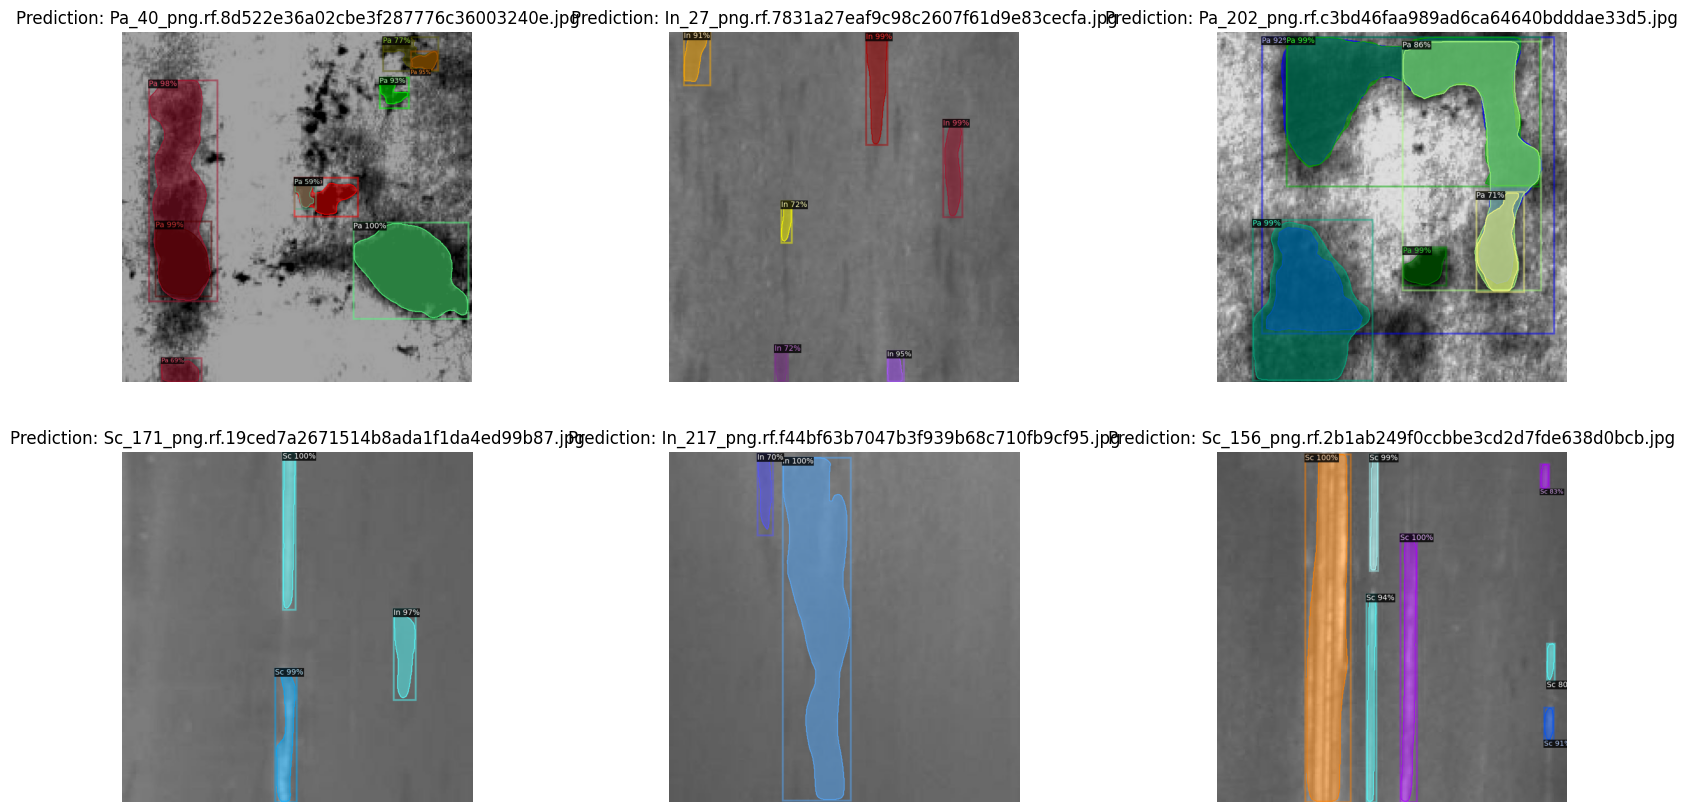

In [17]:
# --- VISUALIZATION SETUP ---
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
import cv2
import random
import matplotlib.pyplot as plt

# 1. Load the weights you just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # 50% confidence threshold
predictor = DefaultPredictor(cfg)

# 2. Get a random image from the VALIDATION set (Domain A)
# We use the validation set because the AI has never seen these images before.
val_dataset_dicts = DatasetCatalog.get("neu_valid")

# Let's look at 3 random images
plt.figure(figsize=(20, 10))
for i in range(6):
    d = random.choice(val_dataset_dicts)
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Visualize
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.subplot(2, 3, i+1)
    plt.imshow(out.get_image())
    plt.title(f"Prediction: {os.path.basename(d['file_name'])}")
    plt.axis('off')

plt.show()

In [ ]:
import os
import torch
import detectron2

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import DatasetMapper

# ----------------------------------------------------------
# 1. Register Dataset
# ----------------------------------------------------------
VAL_DATASET_NAME = "neu_valid"
VAL_JSON = "<Domain_A_evaluation_data_annotations_json_file>"
VAL_IMG_DIR = "<Domain_A_evaluation_data_images>"

# Register once
try:
    register_coco_instances(VAL_DATASET_NAME, {}, VAL_JSON, VAL_IMG_DIR)
except:
    pass

# ----------------------------------------------------------
# 2. Configuration
# ----------------------------------------------------------
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.DATALOADER.NUM_WORKERS = 2

cfg.OUTPUT_DIR = "/home/aamena/Assessment_tcs/output/domain_a_baseline"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# ----------------------------------------------------------
# 3. Evaluator + Loader
# ----------------------------------------------------------
predictor = DefaultPredictor(cfg)
test_mapper = DatasetMapper(cfg, is_train=False)

# FIXED: correct arguments
eval_dataloader = build_detection_test_loader(
    cfg,
    VAL_DATASET_NAME,
    mapper=test_mapper
)

evaluator = COCOEvaluator(
    VAL_DATASET_NAME,
    cfg,
    False,
    output_dir=os.path.join(cfg.OUTPUT_DIR, "validation_results")
)

# ----------------------------------------------------------
# 4. Run Evaluation
# ----------------------------------------------------------
print("🚀 Starting evaluation...")

results = inference_on_dataset(
    predictor.model,
    eval_dataloader,
    evaluator
)

print("\n================================")
print(" FINAL EVALUATION RESULTS")
print("================================")
print(results)


[11/18 18:25:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/aamena/Assessment_tcs/output/domain_a_baseline/model_final.pth ...
[11/18 18:25:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
WARNING [11/18 18:25:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/18 18:25:59 d2.data.datasets.coco]: Loaded 308 images in COCO format from /home/aamena/Assessment_tcs/datasets/NEU-seg-DOMAIN_A/valid/_annotations.coco.json
[11/18 18:25:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/18 18:25:59 d2.data.common]: Serializing 308 elements to byte tensors and concatenating them all ...
[11/18 18:25:59 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [11/18 18:25:59 d2.evaluation.coco_evaluation]: COCO Evaluato

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239

📌 Bounding Box Metrics


,Score
AP,53.106987
AP50,86.157945
AP75,57.564529
APs,7.744551
APm,44.517084
APl,59.164735
"AP-In-""Pa"",-""Sc""",NaN
AP-In,46.231066
AP-Pa,63.194400
AP-Sc,49.895494



📌 Segmentation Metrics


,Score
AP,46.951512
AP50,85.849931
AP75,45.277253
APs,6.824301
APm,37.731073
APl,51.882837
"AP-In-""Pa"",-""Sc""",NaN
AP-In,42.156525
AP-Pa,60.113395
AP-Sc,38.584617


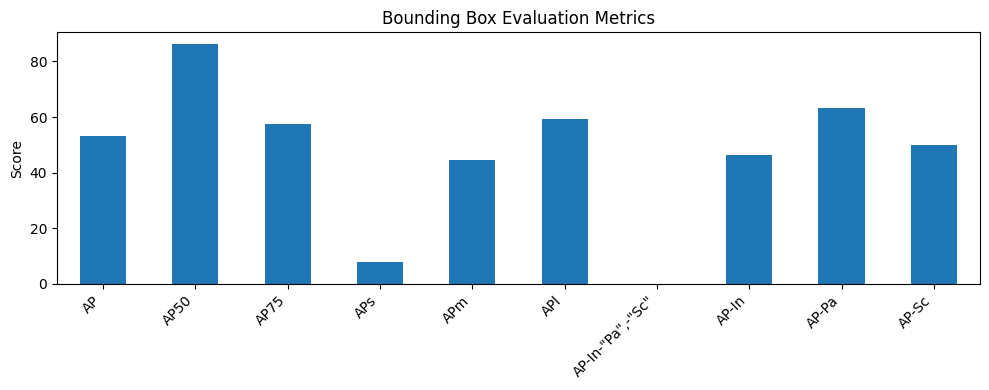

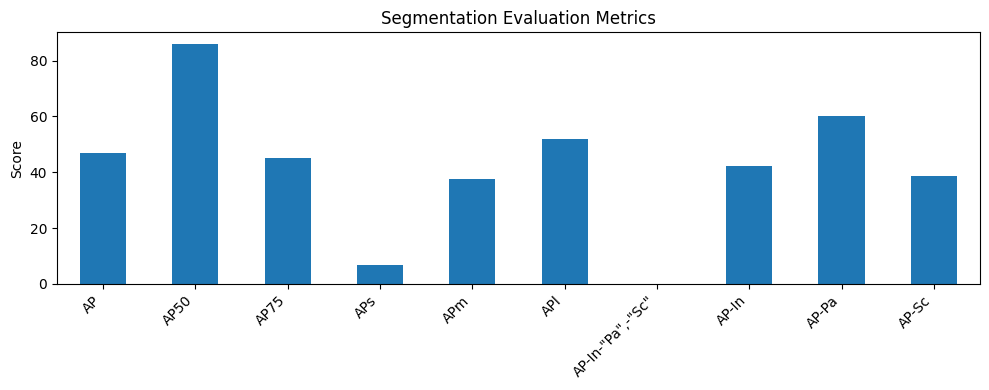

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# Convert Detectron2 COCO results → DataFrames
# ------------------------------------------
bbox_results = results["bbox"]
segm_results = results["segm"]

bbox_df = pd.DataFrame(bbox_results, index=[0]).T.rename(columns={0: "Score"})
segm_df = pd.DataFrame(segm_results, index=[0]).T.rename(columns={0: "Score"})

print("📌 Bounding Box Metrics")
display(bbox_df)

print("\n📌 Segmentation Metrics")
display(segm_df)

# ------------------------------------------
# Plot Bar Charts (ONE CHART PER METRIC TYPE)
# ------------------------------------------

# Bounding Box Chart
plt.figure(figsize=(10, 4))
bbox_df["Score"].plot(kind="bar")
plt.title("Bounding Box Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Segmentation Chart
plt.figure(figsize=(10, 4))
segm_df["Score"].plot(kind="bar")
plt.title("Segmentation Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
